# Upwelling arm definition

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from correlation import Compute_Correlation

import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34211,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.3:43781,Total threads: 4
Dashboard: /proxy/41281/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41487,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 4.22 s, sys: 1.12 s, total: 5.33 s
Wall time: 27.5 s


In [7]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)


CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 16.6 s


In [14]:
def find_lower_upper_indices(hotspot, j_contour):
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        prefix = 400
    else:
        suffix = ''
        prefix = 0
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    
    if hotspot =='MR' and j_contour == 'A' or 'B' or 'J' or 'L' or 'N':
        lon_along_contour[1]=-279.95
    for i in np.arange(prefix,len(lon_along_contour)):
        if lon_along_contour[i]>hotspot_dict[hotspot]['lower_lon']:
            lower_index = i
            break
    for i in np.arange(prefix,len(lon_along_contour)):
        if lon_along_contour[i]<hotspot_dict[hotspot]['upper_lon']:
            upper_index = i
        elif lon_along_contour[i]>hotspot_dict[hotspot]['upper_lon']:
            break

    return lower_index, upper_index



In [15]:
def distance_save(j_contour):
    lat_range = contour_dict[j_contour]['lat_range']
    SSH = contour_dict[j_contour]['SSH']
    dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
    dxu = dxu.sel(yu_ocean = lat_range)
    dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
    dyt = dyt.sel(yt_ocean = lat_range)
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    num_points = len(lat_along_contour)
    lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
    lat_t = lat_t.sel(yt_ocean = lat_range)
    lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
    lon_t = lon_t.sel(yt_ocean = lat_range)
    
    outfile = '/g/data/x77/cy8964/Post_Process/SO_slope_contour_'+str(SSH)+'m_SSH.npz'
    data = np.load(outfile)

        # if there is a bend in the contour, add the distance using length of diagonal, not sum of
    # 2 edges, to be more representative.
    mask_y_transport_numbered = data['mask_y_transport_numbered']
    mask_x_transport_numbered = data['mask_x_transport_numbered']
    contour_masked_above = data['contour_masked_above']

    distance_along_contour = np.zeros((num_points))
    x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
    y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])
    skip = False
    for count in range(1,num_points):
        if skip == True:
            skip = False
            continue
        if count in y_indices:
            if count + 1 in y_indices:
                # note dxu and dyt do no vary in x:
                jj = np.where(mask_y_transport_numbered==count)[0]
                distance_along_contour[count-1] = (dxu[jj,990])[0]
            else:
                jj0 = np.where(mask_y_transport_numbered==count)[0]
                jj1 = np.where(mask_x_transport_numbered==count+1)[0]
                diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
                    (dyt[jj1,990])[0]**2)
                distance_along_contour[count-1] = diagonal_distance
                distance_along_contour[count] = diagonal_distance
                # skip to next count:
                skip = True
        # count in x_indices:
        else:
            if count + 1 in x_indices:
                jj = np.where(mask_x_transport_numbered==count)[0]
                distance_along_contour[count-1] = (dyt[jj,990])[0]
            else:
                jj0 = np.where(mask_x_transport_numbered==count)[0]
                jj1 = np.where(mask_y_transport_numbered==count+1)[0]
                diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
                    (dxu[jj1,990])[0]**2)
                distance_along_contour[count-1] = diagonal_distance
                distance_along_contour[count] = diagonal_distance
                # skip to next count:
                skip = True
    # fix last value:
    if distance_along_contour[-1] == 0:
        count = count + 1
        if count in y_indices:
            jj = np.where(mask_y_transport_numbered==count)[0]
            distance_along_contour[-1] = (dxu[jj,990])[0]
        else:
            jj = np.where(mask_x_transport_numbered==count)[0]
            distance_along_contour[-1] = (dyt[jj,990])[0]

    # units are 10^3 km:
    distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3        
    return distance_along_contour

In [16]:
def distance(hotspot,j_contour):
    distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
    if hotspot == 'KP':
        lower_index1, upper_index1 = find_lower_upper_indices('KP1', j_contour)
        lower_index2, upper_index2 = find_lower_upper_indices('KP2', j_contour)
        dist80 = distance_along_contour[upper_index1]-distance_along_contour[lower_index1]
        distance_along_contour = np.append(distance_along_contour[lower_index1:upper_index1]-distance_along_contour[lower_index1],
                                           distance_along_contour[lower_index2:upper_index2]+dist80)
    else:
        lower_index, upper_index = find_lower_upper_indices(hotspot, j_contour)
        distance_along_contour = distance_along_contour[lower_index:upper_index]-distance_along_contour[lower_index]
        
    return distance_along_contour

In [17]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

In [18]:
#10 degrees bigger on either side, but no overlap
hotspot_dict = OrderedDict([
('PAR',  {'lower_lon':-165,'upper_lon':-100}),
('SWIR',  {'lower_lon':5,'upper_lon':55}),
('DP',  {'lower_lon':-80,'upper_lon':5}),
('MR',  {'lower_lon':-230,'upper_lon':-165}),
('KP1',  {'lower_lon':55,'upper_lon':80}),
('KP2',{'lower_lon':-280,'upper_lon':-230})])#-260

## Saving some data

Want to know the transport integrated over contours in each density bin at each hotspot:

Open eddy transport file for each contour, then for each hotspot sum over it.

Do same for average depth and top and bottom density

(I also saved a masked one which got rid of northward transport, but didn't end up using it)

A
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
P
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
B
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Q
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
C
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
R
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
D
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
S
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
E
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
T
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
F
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
U
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2

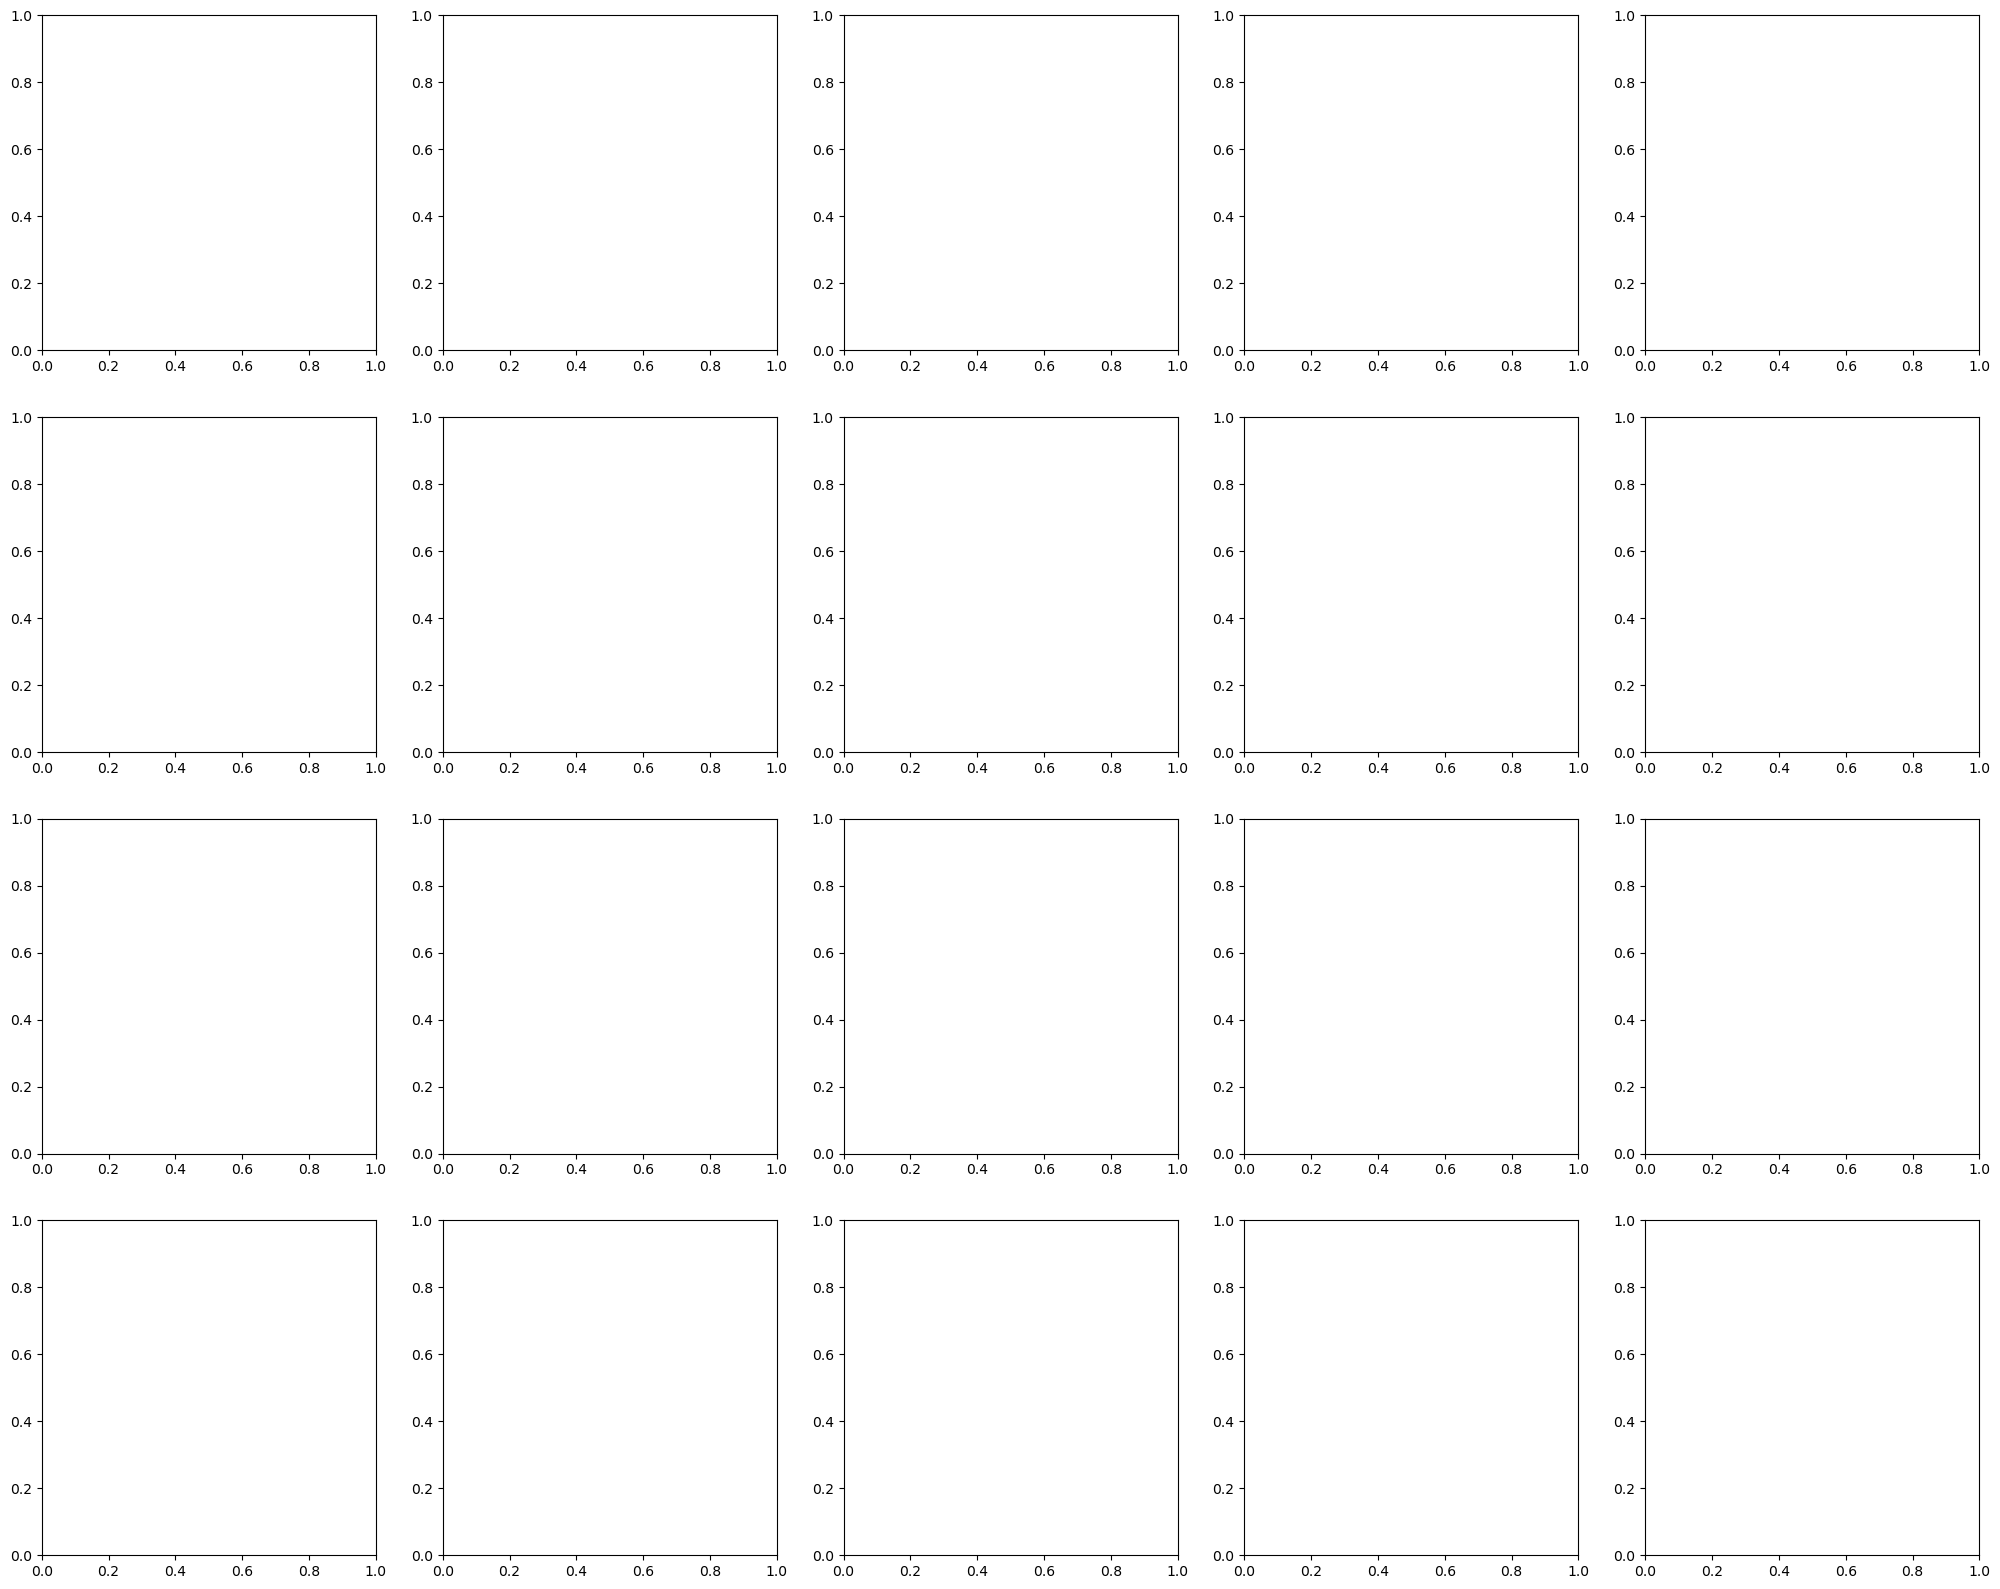

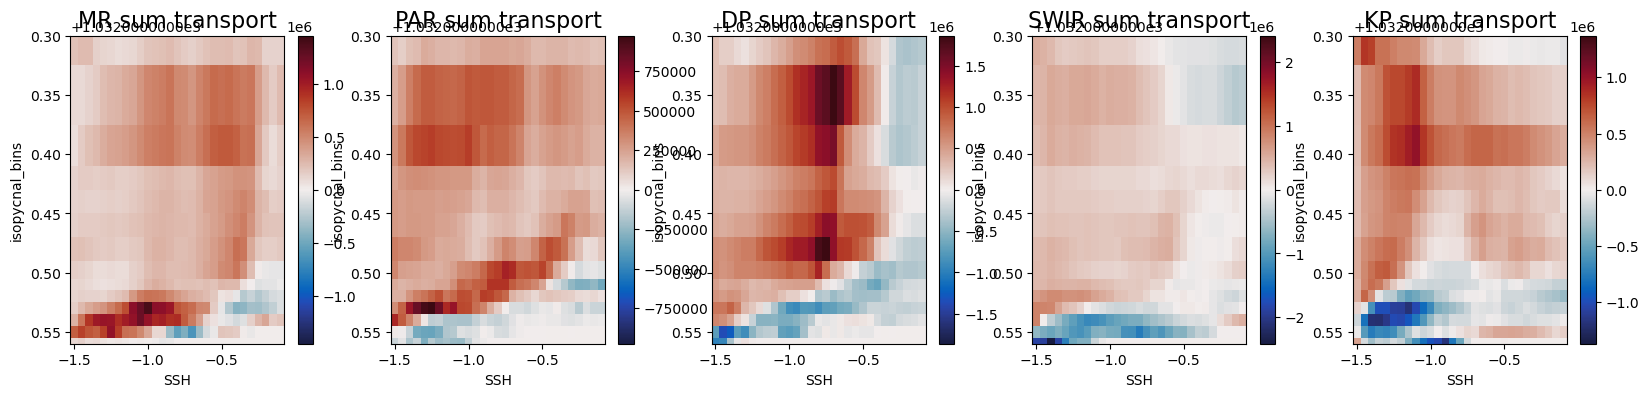

In [22]:
%%time
#10 degrees bigger on either side
#10 degrees bigger on either side, but no overlap
hotspot_dict = OrderedDict([
('PAR',  {'lower_lon':-165,'upper_lon':-100}),
('SWIR',  {'lower_lon':5,'upper_lon':55}),
('DP',  {'lower_lon':-80,'upper_lon':5}),
('MR',  {'lower_lon':-230,'upper_lon':-165}),
('KP1',  {'lower_lon':55,'upper_lon':80}),
('KP2',{'lower_lon':-280,'upper_lon':-230})])#-260
SSHs = np.arange(-0.1,-1.55,-0.05)
densities = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
sum_T_array = xr.DataArray(np.zeros((5,31,29)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP']), densities, SSHs],
                                      dims = ['hotspot', 'isopycnal_bins', 'SSH'],
                                      name = 'sum_T_array')
sum_T_array_masked = xr.DataArray(np.zeros((5,31,29)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP']), densities, SSHs],
                                      dims = ['hotspot', 'isopycnal_bins', 'SSH'],
                                      name = 'sum_T_array_masked')
# distance_array = xr.DataArray(np.zeros((5,31,29)),
#                                       coords = [np.array(['MR','PAR','DP','SWIR','KP']), densities, SSHs],
#                                       dims = ['hotspot', 'isopycnal_bins', 'SSH'],
#                                       name = 'distance_array')

density_mesh = np.append((densities + np.roll(densities,1))/2,46)
fig, axes = plt.subplots(nrows = 4, ncols = 5, figsize = (25,20))
for k in np.arange(0,29):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[k]
    print(j_contour)
    N=10
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
    bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
    vh_eddy_masked= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)
    for i in np.arange(31):
        print(i)
        rho = densities[i]
        eddy_notcumsum = (vh_eddy).sel(isopycnal_bins=rho)
        eddy_notcumsum_masked = (vh_eddy_masked).sel(isopycnal_bins=rho)
        y = uniform_filter1d(eddy_notcumsum.fillna(0), size=N)
        y_masked = uniform_filter1d(eddy_notcumsum_masked.fillna(0), size=N)
        
        for j in np.arange(5):
            hotspot = ['MR','PAR','DP','SWIR','KP'][j]

            # load values at hotpots, scaled by max value
            if hotspot == 'KP':
                lower_index1, upper_index1 = find_lower_upper_indices('KP1', j_contour)
                lower_index2, upper_index2 = find_lower_upper_indices('KP2', j_contour)
                z_hot = np.append(-(y)[lower_index1:upper_index1],-(y)[lower_index2:upper_index2])
                z_hot_masked = np.append(-(y_masked)[lower_index1:upper_index1],-(y_masked)[lower_index2:upper_index2])
            else:
                lower_index, upper_index = find_lower_upper_indices(hotspot, j_contour)
                z_hot = -(y)[lower_index:upper_index]
                z_hot_masked = -(y_masked)[lower_index:upper_index]

            sum_T = np.sum(z_hot)
            sum_T_masked = np.sum(z_hot_masked)
            sum_T_array[j,i,k] = sum_T
            sum_T_array_masked[j,i,k] = sum_T_masked
            
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'sum_T_array': sum_T_array,'sum_T_array_masked': sum_T_array_masked})
ds.to_netcdf(save_dir+'sum_TD_over_hotspots_notoverlapping.nc')
            
fig,axes = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4))          
for j in np.arange(5):
    hotspot = ['MR','PAR','DP','SWIR','KP'][j]
    p1 = sum_T_array_masked.sel(hotspot = hotspot).plot(ax = axes[j],cmap = cm.cm.balance, add_colorbar = False)
    plt.colorbar(p1, ax = axes[j])
    axes[j].set_ylim(1032.56,1032.3)
    axes[j].set_title(hotspot+' sum transport', fontsize = 16)

    


In [111]:
%%time
#10 degrees bigger on either side
#10 degrees bigger on either side, but no overlap
hotspot_dict = OrderedDict([
('PAR',  {'lower_lon':-165,'upper_lon':-100}),
('SWIR',  {'lower_lon':5,'upper_lon':55}),
('DP',  {'lower_lon':-80,'upper_lon':5}),
('MR',  {'lower_lon':-230,'upper_lon':-165}),
('KP1',  {'lower_lon':55,'upper_lon':80}),
('KP2',{'lower_lon':-280,'upper_lon':-230})])#-260
SSHs = np.arange(-0.1,-1.55,-0.05)
densities = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
top_rho = xr.DataArray(np.zeros((6,31,29)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP','total']), densities, SSHs],
                                      dims = ['hotspot', 'isopycnal_bins', 'SSH'],
                                      name = 'top_rho')
bottom_rho = xr.DataArray(np.zeros((6,31,29)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP','total']), densities, SSHs],
                                      dims = ['hotspot', 'isopycnal_bins', 'SSH'],
                                      name = 'bottom_rho')
h_array = xr.DataArray(np.zeros((6,31,29)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP','total']), densities, SSHs],
                                      dims = ['hotspot', 'isopycnal_bins', 'SSH'],
                                      name = 'h')

density_mesh = np.append((densities + np.roll(densities,1))/2,46)
for k in np.arange(0,29):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[k]
    print(j_contour)
    N=10
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    #vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
    bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
    h_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_dzu_across_contour_binned.nc').dzu_across_contour_binned
    h_contour = h_contour.mean('time')
    #vh_eddy_masked= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)
    for i in np.arange(31):
        print(i)
        rho = densities[i]
        top_rho1_max_contour_i = top_rho1_max_contour#.sel(isopycnal_bins = rho)
        bottom_rho1_min_contour_i = bottom_rho1_min_contour#.sel(isopycnal_bins = rho)
        h_contour_i = h_contour.sel(isopycnal_bins = rho)
         
        for j in np.arange(5):
            hotspot = ['MR','PAR','DP','SWIR','KP'][j]

            # load values at hotpots, scaled by max value
            if hotspot == 'KP':
                lower_index1, upper_index1 = find_lower_upper_indices('KP1', j_contour)
                lower_index2, upper_index2 = find_lower_upper_indices('KP2', j_contour)
                top_rho_j = np.append((top_rho1_max_contour_i)[lower_index1:upper_index1],top_rho1_max_contour_i[lower_index2:upper_index2])
                bottom_rho_j = np.append(bottom_rho1_min_contour_i[lower_index1:upper_index1],bottom_rho1_min_contour_i[lower_index2:upper_index2])
                h_j = np.append(h_contour_i[lower_index1:upper_index1],h_contour_i[lower_index2:upper_index2])
                
            else:
                lower_index, upper_index = find_lower_upper_indices(hotspot, j_contour)
                top_rho_j = (top_rho1_max_contour_i)[lower_index:upper_index]
                bottom_rho_j = bottom_rho1_min_contour_i[lower_index:upper_index]
                h_j = h_contour_i[lower_index:upper_index]

            top_rho[j,i,k] = top_rho_j.mean()#.values
            bottom_rho[j,i,k] = bottom_rho_j.mean()#.values
            h_array[j,i,k] = h_j.mean()#.values
            
        top_rho[5,i,k] = top_rho1_max_contour_i.mean()#.values
        bottom_rho[5,i,k] = bottom_rho1_min_contour_i.mean()#.values
        h_array[5,i,k] = h_contour_i.mean()#.values
        
            
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'top_rho': top_rho,'bottom_rho': bottom_rho, 'h':h_array})
ds.to_netcdf(save_dir+'rho_and_h_on_contours.nc')
            
# fig,axes = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4))          
# for j in np.arange(5):
#     hotspot = ['MR','PAR','DP','SWIR','KP'][j]
#     p1 = sum_T_array_masked.sel(hotspot = hotspot).plot(ax = axes[j],cmap = cm.cm.balance, add_colorbar = False)
#     plt.colorbar(p1, ax = axes[j])
#     axes[j].set_ylim(1032.56,1032.3)
#     axes[j].set_title(hotspot+' sum transport', fontsize = 16)

    


A
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
P
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
B
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Q
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
C
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
R
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
D
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
S
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
E
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
T
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
F
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
U
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2

A
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
P
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
B
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Q
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
C
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
R
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
D
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
S
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
E
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
T
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
F
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
U
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2

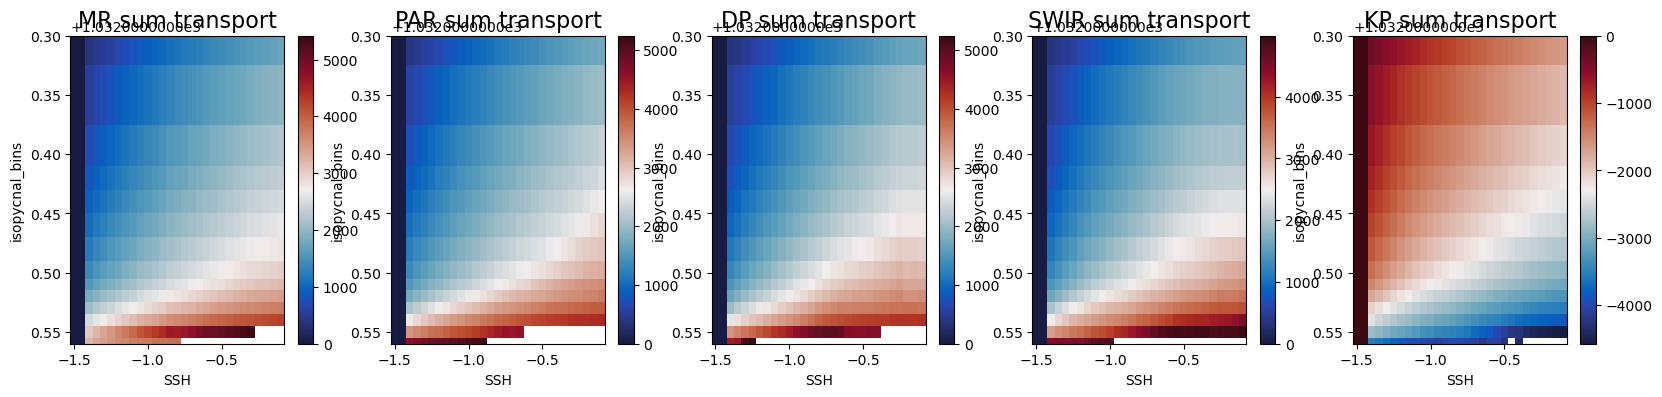

In [21]:
%%time
#save h along contours
hotspot_dict = OrderedDict([
('PAR',  {'lower_lon':-165,'upper_lon':-100}),
('SWIR',  {'lower_lon':5,'upper_lon':55}),
('DP',  {'lower_lon':-80,'upper_lon':5}),
('MR',  {'lower_lon':-230,'upper_lon':-165}),
('KP1',  {'lower_lon':55,'upper_lon':80}),
('KP2',{'lower_lon':-280,'upper_lon':-230})])#-260
SSHs = np.arange(-0.1,-1.55,-0.05)
densities = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
sum_T_array_masked = xr.DataArray(np.zeros((5,31,29)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP']), densities, SSHs],
                                      dims = ['hotspot', 'isopycnal_bins', 'SSH'],
                                      name = 'sum_T_array_masked')

density_mesh = np.append((densities + np.roll(densities,1))/2,46)
for k in np.arange(0,27):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[k]
    print(j_contour)
    N=10
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    h_0 = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_dzu_across_contour_binned.nc').dzu_across_contour_binned
    h_0 = h_0.cumsum('isopycnal_bins').mean('time')
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    isopycnal_bin_contour = h_0*0+h_0.isopycnal_bins
    top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').top_rho1_max_contour
    bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour'+suffix+'.nc').bottom_rho1_min_contour
    vh_eddy_masked= h_0.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour)#.fillna(0)
    for i in np.arange(31):
        print(i)
        rho = densities[i]
        eddy_notcumsum_masked = (vh_eddy_masked).sel(isopycnal_bins=rho)
        #y_masked = uniform_filter1d(eddy_notcumsum_masked.fillna(0), size=N)
        y_masked = eddy_notcumsum_masked.values
        for j in np.arange(5):
            hotspot = ['MR','PAR','DP','SWIR','KP'][j]

            # load values at hotpots, scaled by max value
            if hotspot == 'KP':
                lower_index1, upper_index1 = find_lower_upper_indices('KP1', j_contour)
                lower_index2, upper_index2 = find_lower_upper_indices('KP2', j_contour)
                z_hot_masked = np.append(-(y_masked)[lower_index1:upper_index1],-(y_masked)[lower_index2:upper_index2])
            else:
                lower_index, upper_index = find_lower_upper_indices(hotspot, j_contour)
                z_hot_masked = (y_masked)[lower_index:upper_index]

            sum_T_masked = np.nanmean(z_hot_masked)
            sum_T_array_masked[j,i,k] = sum_T_masked
            
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'mean_h_array_masked': sum_T_array_masked})
ds.to_netcdf(save_dir+'mean_h_over_hotspots_notoverlapping_nozerov2.nc')
            
fig,axes = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4))          
for j in np.arange(5):
    hotspot = ['MR','PAR','DP','SWIR','KP'][j]
    p1 = sum_T_array_masked.sel(hotspot = hotspot).plot(ax = axes[j],cmap = cm.cm.balance, add_colorbar = False)
    plt.colorbar(p1, ax = axes[j])
    axes[j].set_ylim(1032.56,1032.3)
    axes[j].set_title(hotspot+' sum transport', fontsize = 16)

    


# Open saved along-contour stuff

In [87]:
sum_T_array=xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/sum_TD_over_hotspots_notoverlapping.nc').sum_T_array
sum_T_array_masked=xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/sum_TD_over_hotspots_notoverlapping.nc').sum_T_array_masked
depth_array=xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/mean_h_over_hotspots_notoverlapping_nozerov2.nc').mean_h_array_masked


In [88]:
sum_T_array_tot=xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/sum_TD_total.nc').sum_T_array.sel(hotspot = 'total')
sum_T_array_tot_masked=xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/sum_TD_total.nc').sum_T_array_masked.sel(hotspot = 'total')


In [89]:

top_rho = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/rho_and_h_on_contours.nc').top_rho
bottom_rho = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/rho_and_h_on_contours.nc').bottom_rho
h = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/rho_and_h_on_contours.nc').h


# Find where bottom is - either density or southward transport

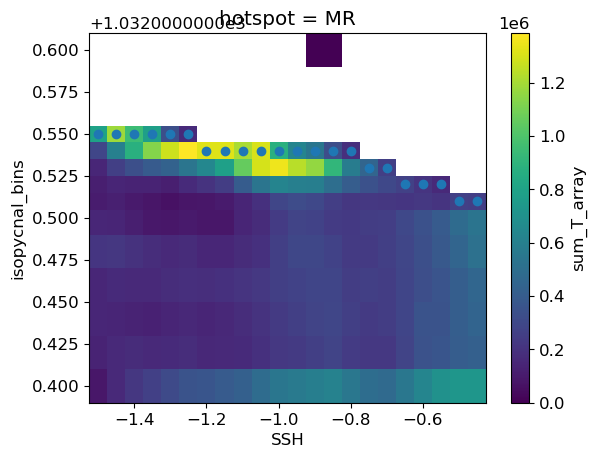

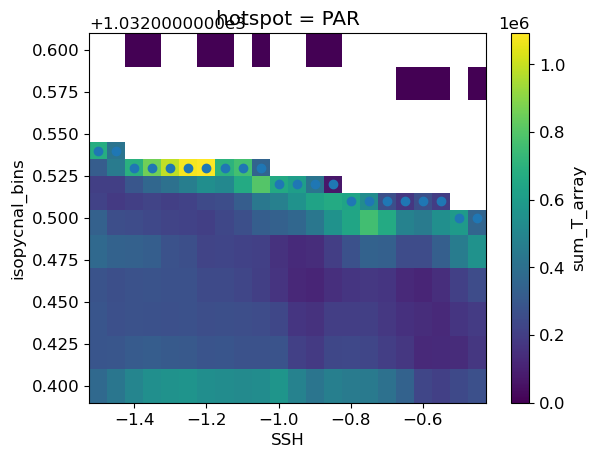

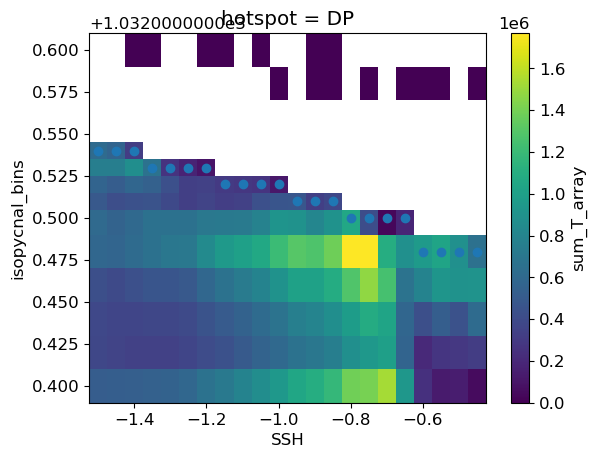

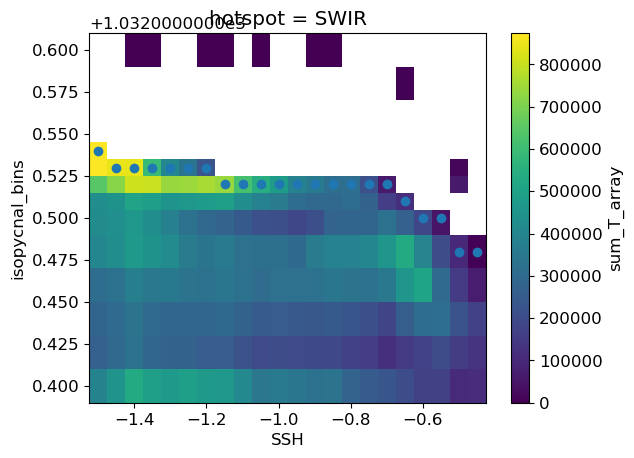

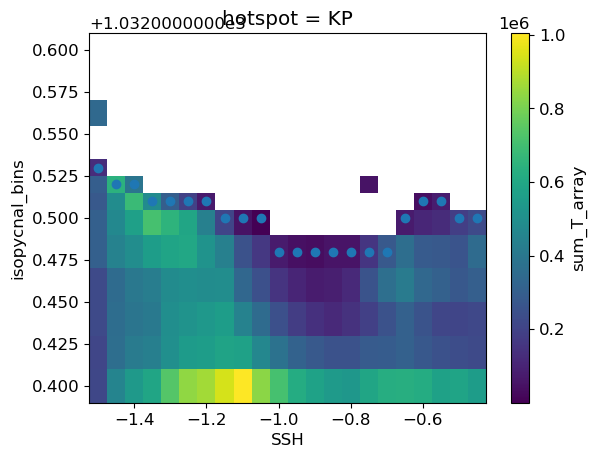

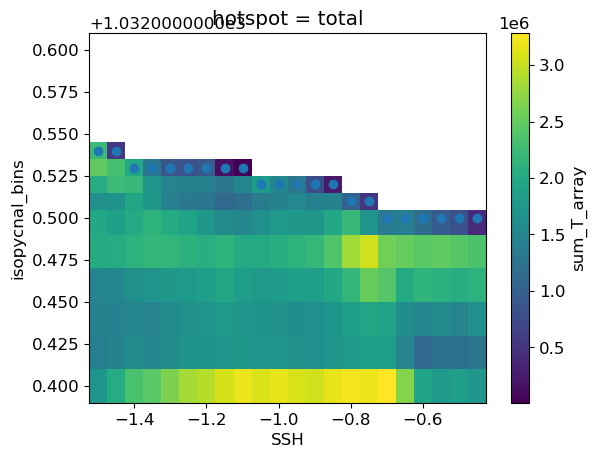

In [150]:
bottom_cutoff = xr.DataArray(np.zeros((6,22)),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP','total']), np.arange(-1.5,-0.44,0.05)],
                                      dims = ['hotspot', 'SSH'],
                                      name = 'bottom_cutoff')

for k in np.arange(5):
    hotspot = ['MR','PAR','DP','SWIR','KP'][k]

    sum_T_array_bottom = sum_T_array.sel(hotspot = hotspot).sel(isopycnal_bins = slice(1032.4,1032.6)).isel(SSH = np.arange(7,29) )
    sum_T_array_bottom.where(sum_T_array_bottom >0).plot()
    #sum_T_array.sel(hotspot = hotspot).plot()
    for i in np.arange(len(sum_T_array_bottom.SSH)):
        for j in np.arange(len(sum_T_array_bottom.isopycnal_bins)):
            if np.isnan(sum_T_array_bottom.where(sum_T_array_bottom >0)[j,i])==True:
                if bottom_cutoff[k,21-i]==0:
                    bottom_cutoff[k,21-i] = sum_T_array_bottom.isopycnal_bins[j-1]
    plt.scatter(bottom_cutoff.SSH.values,bottom_cutoff[k,:])
    plt.show()
hotspot = 'total'
sum_T_array_bottom = sum_T_array_tot.sel(isopycnal_bins = slice(1032.4,1032.6)).isel(SSH = np.arange(7,29) )
sum_T_array_bottom.where(sum_T_array_bottom >0).plot()
#sum_T_array.sel(hotspot = hotspot).plot()
for i in np.arange(len(sum_T_array_bottom.SSH)):
    for j in np.arange(len(sum_T_array_bottom.isopycnal_bins)):
        if np.isnan(sum_T_array_bottom.where(sum_T_array_bottom >0)[j,i])==True:
            if bottom_cutoff[5,21-i]==0:
                bottom_cutoff[5,21-i] = sum_T_array_bottom.isopycnal_bins[j-1]
plt.scatter(bottom_cutoff.SSH.values,bottom_cutoff[5,:])
plt.show()

In [151]:
top_cutoff = xr.DataArray(np.flip(top_rho.isel(isopycnal_bins = 0).isel(SSH = np.arange(7,29)).values, axis = 1),
                                      coords = [np.array(['MR','PAR','DP','SWIR','KP','total']), bottom_cutoff.SSH.values],
                                      dims = ['hotspot', 'SSH'],
                                      name = 'top_cutoff')


In [152]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'top_cutoff': top_cutoff})
ds.to_netcdf(save_dir+'hotspot_top_density_cutoffs.nc')

# listed are the upwelling arm ranges

In [24]:
top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff

bottom_cutoff.min('SSH')#.sel(SSH = slice(-0.86,-0.84)).sel(hotspot = 'total')#.values[1]

<xarray.DataArray 'bottom_cutoff' (hotspot: 6)>
array([1032.51, 1032.5 , 1032.48, 1032.48, 1032.48, 1032.5 ])
Coordinates:
  * hotspot  (hotspot) object 'MR' 'PAR' 'DP' 'SWIR' 'KP' 'total'

In [25]:
top_cutoff.max('SSH')

<xarray.DataArray 'top_cutoff' (hotspot: 6)>
array([1032.2962295 , 1032.22305317, 1032.13010113, 1032.13490907,
       1032.19249245, 1032.20006365])
Coordinates:
  * hotspot  (hotspot) object 'MR' 'PAR' 'DP' 'SWIR' 'KP' 'total'